In [ ]:
import pandas as pd

pos_df = pd.read_csv("/content/dlt_subset_filtered.csv")
df = pd.read_csv("/content/dlt_subset.csv")

In [ ]:
joined_df = df.set_index("predictions").join(pos_df.set_index("predictions"), rsuffix="_pos").reset_index(drop=False)

In [ ]:
joined_df["class"].fillna(0, inplace=True)

/tmp/ipython-input-4-1268063980.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joined_df["class"].fillna(0, inplace=True)


<Axes: title={'center': 'tok_len'}, xlabel='class'>

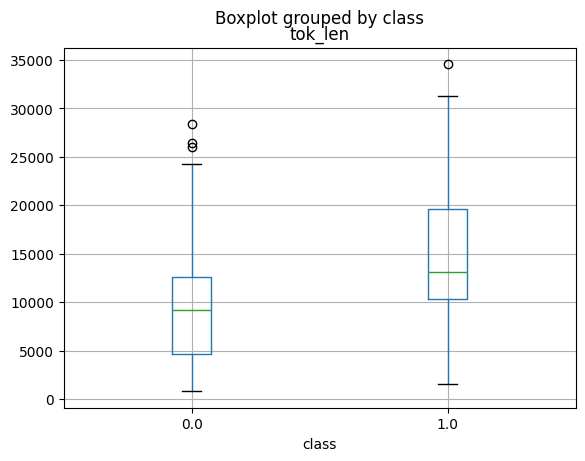

In [ ]:
joined_df.boxplot("tok_len", by="class")

In [ ]:
joined_df["num_preds"] = joined_df["predictions"].str.len()

<Axes: title={'center': 'num_preds'}, xlabel='class'>

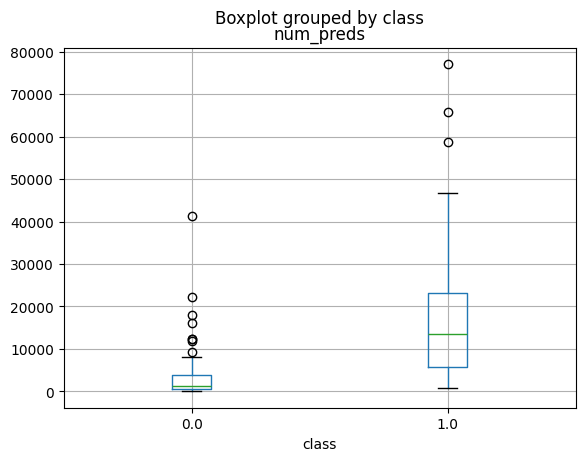

In [ ]:
joined_df.boxplot("num_preds", by="class")

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(joined_df["class"], joined_df["num_preds"] > 7000)

0.79

In [ ]:
from tqdm.auto import tqdm
import ast

def parse_predictions_column(predictions_str: str):
  try:
      # Handle the multi-line format by splitting and rejoining properly
      lines = predictions_str.split('\n')
      lines = [line.strip() for line in lines if line.strip()]

      # Remove brackets from first and last lines
      if lines[0].startswith('['):
          lines[0] = lines[0][1:]
      if lines[-1].endswith(']'):
          lines[-1] = lines[-1][:-1]
  # Join with commas to create valid list format
      full_str = '[' + ','.join(lines) + ']'

      # Use ast.literal_eval to safely parse Python literal
      return ast.literal_eval(full_str)
  except Exception as e:
      print(f"Error parsing predictions: {e}")
      return []

tqdm.pandas()
joined_df["predictions"] = joined_df["predictions"].progress_apply(
    lambda x: parse_predictions_column(x)
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
joined_df["prediction_max"] = joined_df["predictions"].apply(
    lambda x: max([0] + [y["score"] for y in x if y["entity_group"] != "ESG"])
)

In [ ]:
joined_df["predictions"][0]

[{'end': 1599,
  'entity_group': 'Security_Privacy',
  'score': 0.7383297085762024,
  'start': 1585,
  'word': ' function—this'},
 {'end': 929,
  'entity_group': 'Consensus',
  'score': 0.635273277759552,
  'start': 915,
  'word': ' combinatorial'},
 {'end': 1489,
  'entity_group': 'Security_Privacy',
  'score': 0.7007311582565308,
  'start': 1479,
  'word': ' functions'},
 {'end': 2232,
  'entity_group': 'ESG',
  'score': 0.7548346519470215,
  'start': 2216,
  'word': ' computationally'},
 {'end': 588,
  'entity_group': 'Security_Privacy',
  'score': 0.6960213780403137,
  'start': 578,
  'word': ' functions'},
 {'end': 1036,
  'entity_group': 'Security_Privacy',
  'score': 0.7135512232780457,
  'start': 1027,
  'word': ' function'},
 {'end': 155,
  'entity_group': 'Security_Privacy',
  'score': 0.55644291639328,
  'start': 145,
  'word': ' Oblivious'},
 {'end': 725,
  'entity_group': 'Security_Privacy',
  'score': 0.7492476105690002,
  'start': 715,
  'word': ' Oblivious'},
 {'end': 9

<Axes: title={'center': 'prediction_max'}, xlabel='class'>

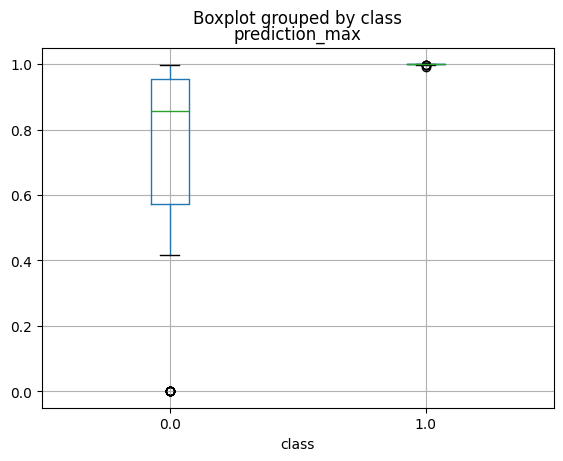

In [ ]:
joined_df.boxplot("prediction_max", by="class")

In [ ]:
joined_df.groupby("class")["prediction_max"].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0.0,64.0,0.703730,0.340618,0.00000,0.573633,0.857954,0.955645,0.997228
1.0,36.0,0.999206,0.001590,0.99143,0.999288,0.999794,0.999979,1.000000


In [ ]:
from sklearn.metrics import accuracy_score

accs = [
    {
        "acc": accuracy_score(joined_df["class"], joined_df["prediction_max"] > i / 10000),
        "threshold": i / 10000
    } for i in range(9900, 10001)]

<Axes: xlabel='threshold'>

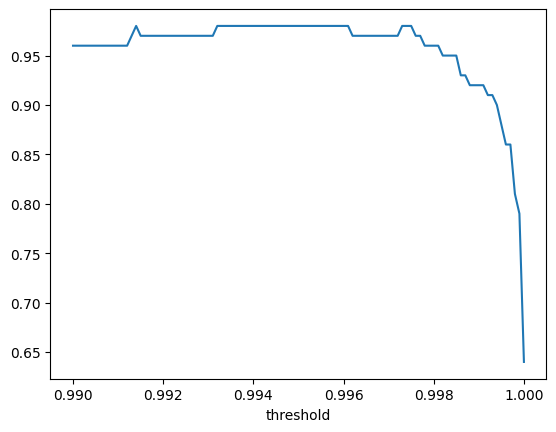

In [ ]:
pd.DataFrame(accs).set_index("threshold")["acc"].plot()

In [ ]:
joined_df["final_pred"] = joined_df["prediction_max"] > 0.995

In [ ]:
joined_df[joined_df["final_pred"]]["class"].value_counts()

,count
class,
1.0,35
0.0,1


In [ ]:
joined_df[~joined_df["final_pred"]]["class"].value_counts()

,count
class,
0.0,63
1.0,1


In [ ]:
from datasets import Dataset

Dataset.from_pandas(joined_df[
    ["predictions", "text", "tok_len", "lang", "lang_conf", "class"]
])#.push_to_hub(
#     "ExponentialScience/dlt-articles-classification",
#     private=True
# )


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
joined_df

,predictions,text,tok_len,lang,lang_conf,class,tok_len_pos,num_preds,prediction_max,final_pred
0,"[{'end': 1599, 'entity_group': 'Security_Priva...",# Completeness Theorems with Constructive Proo...,18751,en,0.827709,0.0,NaN,1704,0.988700,False
1,"[{'end': 1723, 'entity_group': 'ESG', 'score':...",### IOSR Journal of Mechanical and Civil Engin...,9026,en,0.863575,0.0,NaN,2606,0.993177,True
2,"[{'end': 72, 'entity_group': 'Security_Privacy...",# Improving Privacy and Trust in Federated Ide...,5666,en,0.893756,1.0,5666.0,16372,0.999758,True
3,"[{'end': 295, 'entity_group': 'Identity_Manage...",# Rapid maxillary expansion treatment could pr...,1187,en,0.915306,0.0,NaN,232,0.628579,False
4,"[{'end': 623, 'entity_group': 'ESG', 'score': ...",# sensors\n\n_Article_\n## Wireless Sensor Net...,17976,en,0.884699,0.0,NaN,7586,0.997228,True
...,...,...,...,...,...,...,...,...,...,...
95,"[{'end': 1680, 'entity_group': 'Consensus', 's...",# Usurp: Distributed NAT Traversal for Overlay...,10425,en,0.822953,1.0,10425.0,9989,0.999947,True
96,"[{'end': 133, 'entity_group': 'ESG', 'score': ...",# microorganisms\n\n_Article_\n# Bacterial Com...,18609,en,0.877413,0.0,NaN,17881,0.976679,False
97,"[{'end': 259, 'entity_group': 'Transaction_Cap...",# Introduction to the Special Issue on TLS 1.3...,1582,en,0.893521,1.0,1582.0,2286,0.998714,True
98,"[{'end': 528, 'entity_group': 'ESG', 'score': ...",**Original Investigation | Pediatrics**\n## Ac...,10710,en,0.870236,0.0,NaN,411,0.416604,False
